In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [3]:
def sphere(individuo):
    resultado = 0
    for i in individuo:
        resultado += i ** 2
    return resultado
    
def rastrigin(individuo):
    resultado = 0
    for i in individuo:
        numero = 2*3.1415*i
        p = (numero/180)*math.pi
        resultado+= (i**2) - (10 * math.cos(p)) + 10    
    return resultado
    
def rosenbrock(individuo):
    resultado = 0
    for i in range(0,(len(individuo)-1)):
        resultado += 100*(individuo[i+1] - individuo[i]**2)**2 + (individuo[i] - 1)**2   
    return resultado

## Algoritmo ABC

In [7]:
class FonteAlimentacao:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, fator_abandono:int, funcao_fitness):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        self.posicao = np.random.uniform(limite_min, limite_max, dimensoes)
        self.fator_abandono = fator_abandono

        self.fitness = funcao_fitness(self.posicao)
        self.tentativas = 0
    
    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class Abelha:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, funcao_fitness, fonte = None):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        if fonte is not None:
            self.posicao = np.copy(fonte.posicao)
            self.fonte = fonte
            self.fitness = funcao_fitness(self.posicao)
        else:
            self.posicao = None
            self.fonte = None
            self.fitness = 0

    def calcular_posicao(self, fontes):
        indice_dimensao = random.randint(0, self.dimensoes - 1)
        indice_fonte = random.randint(0, len(fontes) - 1)
        while fontes[indice_fonte] == self.fonte:
            indice_fonte = random.randint(0, len(fontes) - 1)

        fator_aleatorio = random.uniform(-1, 1)
        nova_posicao = self.fonte.posicao[indice_dimensao] + fator_aleatorio * (
            self.fonte.posicao[indice_dimensao] - fontes[indice_fonte].posicao[indice_dimensao])
        
        nova_posicao = np.clip(nova_posicao, self.limite_min, self.limite_max)
        self.posicao[indice_dimensao] = nova_posicao

    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class AlgoritmoABC:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, tamanho_populacao:int, fator_abandono:int, ciclos:int, funcao_fitness):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max

        self.tamanho_populacao = tamanho_populacao
        self.fator_abandono = fator_abandono
        self.ciclos = ciclos
        self.funcao_fitness = funcao_fitness

        self.melhor_posicao = None
        self.melhor_fitness = float('inf')
        self.ciclo_best = 0

    def gerar_fontes(self):
        return [FonteAlimentacao(self.dimensoes, self.limite_min, self.limite_max, self.fator_abandono, self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2))]
    
    def gerar_abelhas_empregadas(self, fontes):
        return [Abelha(self.dimensoes, self.limite_min, self.limite_max, self.funcao_fitness, fonte=fonte) for fonte in fontes]
    
    def gerar_abelhas_observadoras(self):
        return [Abelha(dimensoes=self.dimensoes, limite_min=self.limite_min, limite_max=self.limite_max, funcao_fitness=self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2)) ]

    def executar_abelhas_empregadas(self, abelhas_empregadas, fontes):
        for abelha in abelhas_empregadas:
            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()
            fonte_abelha = abelha.fonte
            
            if abelha.fitness < fonte_abelha.fitness:
                fonte_abelha.posicao = np.copy(abelha.posicao)
                fonte_abelha.calcular_fitness()
                fonte_abelha.tentativas = 0
            else:
                fonte_abelha.tentativas += 1

    def selecionar_fonte_roleta(self, fontes):
        lista_fitness_minimo = [1 / (fonte.fitness) for fonte in fontes]
        total_fitness_minimo = sum(lista_fitness_minimo)
        probabilidades = [valor / total_fitness_minimo for valor in lista_fitness_minimo]

        return random.choices(fontes, weights=probabilidades, k=1)[0]
    
    def executar_abelhas_observadoras(self, abelhas_observadoras, fontes):
        for abelha in abelhas_observadoras:
            fonte_selecionada = self.selecionar_fonte_roleta(fontes)
            abelha.fonte = fonte_selecionada
            abelha.posicao = np.copy(fonte_selecionada.posicao)

            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()

            if abelha.fitness < fonte_selecionada.fitness:
                fonte_selecionada.posicao = np.copy(abelha.posicao)
                fonte_selecionada.calcular_fitness()
                fonte_selecionada.tentativas = 0
            else:
                fonte_selecionada.tentativas += 1

    def executar_abelhas_exploradoras(self, fontes):
        for fonte in fontes:
            if fonte.tentativas >= self.fator_abandono:
                fonte.posicao = np.random.uniform(self.limite_min, self.limite_max, self.dimensoes)
                fonte.calcular_fitness()
                fonte.tentativas = 0

    def plotar_grafico_convergencia(self, historico_fitness, funcao_fitness):
        x = [i for i in range(1, len(historico_fitness) + 1)]
        y = historico_fitness

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Ciclo')
        plt.xlabel('Ciclo')
        plt.ylabel('Melhor Fitness')
        plt.title(f'Gráfico de Convergência do ABC - {funcao_fitness}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def executar(self):
        historico_fitness = []

        fontes = self.gerar_fontes()
        abelhas_empregadas = self.gerar_abelhas_empregadas(fontes=fontes)
        abelhas_observadores = self.gerar_abelhas_observadoras()

        for ciclo in range(self.ciclos):
            self.executar_abelhas_empregadas(abelhas_empregadas=abelhas_empregadas, fontes=fontes)
            self.executar_abelhas_observadoras(abelhas_observadoras=abelhas_observadores, fontes=fontes)
            self.executar_abelhas_exploradoras(fontes=fontes)

            for fonte in fontes:
                if fonte.fitness < self.melhor_fitness:
                    self.melhor_fitness = fonte.fitness
                    self.melhor_posicao = np.copy(fonte.posicao)
                    self.ciclo_best = ciclo
                    
            historico_fitness.append(self.melhor_fitness)
        
        return historico_fitness
    
    def exibir_melhor_fitness(self):
        print(f'Ciclo {self.ciclo_best} - Melhor Fitness: {self.melhor_fitness} - Melhor Posição: {self.melhor_posicao}')
            

### Execução do ABC - Sphere

Ciclo 553 - Melhor Fitness: 7579.700617767169 - Melhor Posição: [ 23.51934919 -37.49473614  21.16792149  40.93284104  10.35245368
   5.55074649   3.83130998  -8.20102    -21.53688632 -14.17418893
 -17.57872137  13.24337863  18.52965528   4.65333107  11.14114295
   5.42324735  15.02868652   1.74573281  29.9738775  -21.95821521]


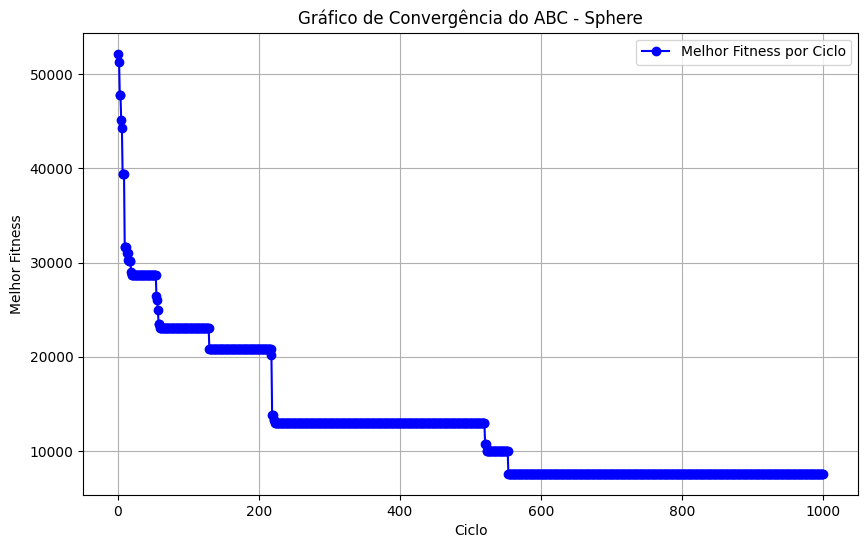

In [17]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-100.0,
                   limite_max=100.0,
                   tamanho_populacao=10,
                   fator_abandono=5,
                   ciclos=1000,
                   funcao_fitness=sphere)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Sphere")


### Execução do ABC - Rastrigin

Ciclo 91 - Melhor Fitness: 1787.0637224725915 - Melhor Posição: [  3.58957262   0.07988042  -1.02339332   7.05075494 -19.51405946
   2.27775445  -2.66406727  -7.68578281  14.10472792   8.08799723
   0.24979259   0.83264169  -7.5711654   12.31750811  -4.53192117
  22.66605078 -11.40127198  -2.14888575   1.83539704   6.92320288]


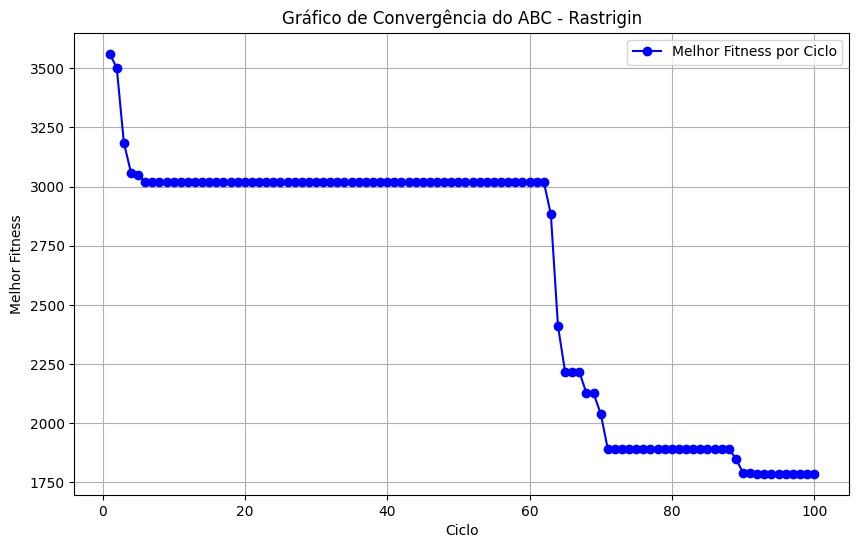

In [9]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-30.0,
                   limite_max=30.0,
                   tamanho_populacao=10,
                   fator_abandono=5,
                   ciclos=100,
                   funcao_fitness=rastrigin)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rastrigin")


### Execução do ABC - Rosenbrock

Ciclo 98 - Melhor Fitness: 62832.351897946966 - Melhor Posição: [-1.0603865   0.52614108 -3.1035249  -2.16167947 -2.72599278  1.80838351
 -0.15098415  2.9346305   3.93232801 -1.60868757 -0.16393061 -1.78376249
  0.19832802 -0.5216155   1.65955138 -0.10633678  1.52510974 -0.93566535
  1.20184913  5.12      ]


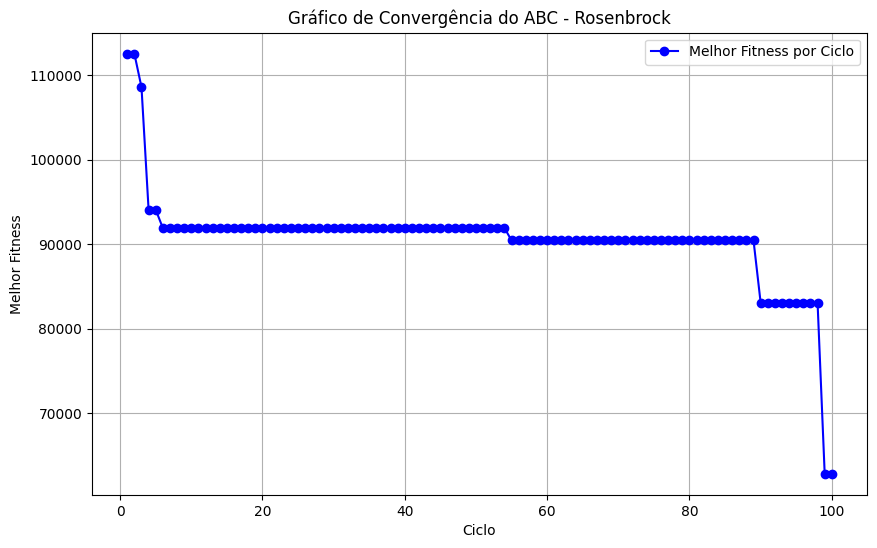

In [14]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-5.12,
                   limite_max=5.12,
                   tamanho_populacao=10,
                   fator_abandono=5,
                   ciclos=100,
                   funcao_fitness=rosenbrock)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rosenbrock")
